In [13]:
from google.colab import drive
drive.flush_and_unmount()  # This will disconnect the drive




In [14]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [24]:
# Part 1: Load and Preprocess Images

# Import necessary libraries
import os
import numpy as np
from PIL import Image

# Define a function to load and resize images from a folder
def load_and_resize_images(folder_path, size=(128, 128)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):  # Only load JPG images
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img = img.resize(size)  # Resize the image
                images.append(np.array(img))  # Convert to numpy array and store
    return images

# Define the base path for the breed folders
base_path = "/content/gdrive/MyDrive/CMPE-255/Assignment_6/train"  # Replace with the actual path to the Train directory

# List of breed folders
breed_folders = os.listdir(base_path)

# Load and preprocess images from each breed folder and create breed labels
all_images = []  # This will store all the images as numpy arrays
breed_labels = []  # This will store the corresponding breed labels

for breed in breed_folders:
    folder_path = os.path.join(base_path, breed)
    breed_images = load_and_resize_images(folder_path)
    all_images.extend(breed_images)  # Add the breed images to the all_images list
    breed_labels.extend([breed] * len(breed_images))  # Add the breed name to breed_labels for each image

# Optionally, display some statistics about the loaded images
print(f"Total number of images: {len(all_images)}")
print(f"Example breed labels: {breed_labels[:5]}")  # Display the first 5 breed labels as an example


Total number of images: 1380
Example breed labels: ['Cairn', 'Cairn', 'Cairn', 'Cairn', 'Cairn']


In [31]:
# Part 2: Generate Embeddings Using ResNet50

# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

# Load the ResNet50 model pre-trained on ImageNet data
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')

# Function to preprocess images and generate embeddings
def generate_embeddings(images):
    processed_images = np.array([preprocess_input(img_to_array(img)) for img in images])
    embeddings = model.predict(processed_images, batch_size=32)
    return embeddings

# The all_images list already contains the images, so we directly pass it to the embedding function
embeddings = generate_embeddings(all_images)

# Check if the embeddings have been generated successfully
print(f"Number of embeddings generated: {len(embeddings)}")


44/44 [==============================] - 78s 2s/step
Number of embeddings generated: 1380


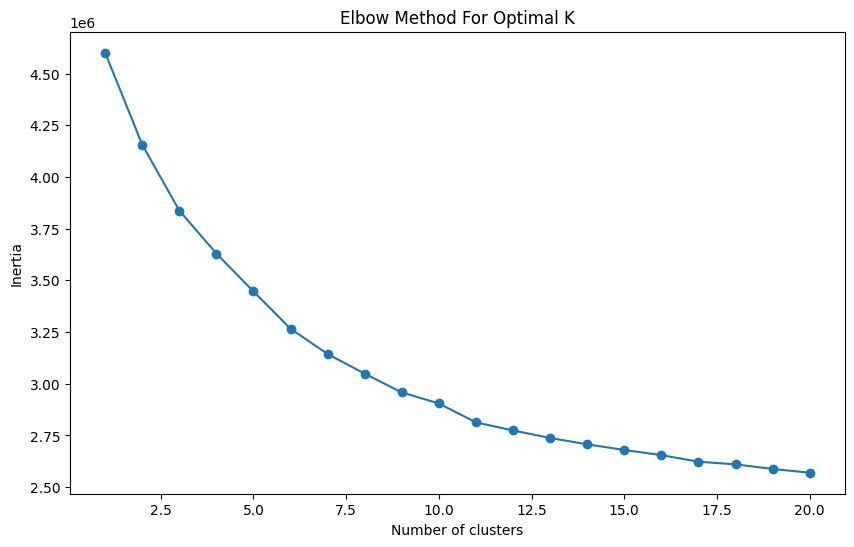

Cluster assignments: [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


In [32]:
# Part 3: K-means Clustering - Corrected

# Import necessary libraries
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Determine the optimal number of clusters using the Elbow method
def find_optimal_clusters(data, max_k=20):
    inertia = []
    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42).fit(data)
        inertia.append(kmeans.inertia_)

    # Plotting the Elbow graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), inertia, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method For Optimal K')
    plt.show()

# Using the Elbow method to find the optimal number of clusters
find_optimal_clusters(embeddings)

# Decide the optimal number of clusters based on the Elbow plot
# Replace 10 with the number of clusters you determined to be optimal after observing the plot
optimal_clusters = 10

# Perform K-means clustering with the chosen number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(embeddings)

# Check the clustering result
print(f"Cluster assignments: {clusters[:20]}")  # Display the first 20 cluster assignments as a sample


In [33]:
print(f"Number of images: {len(processed_images)}")
print(f"Number of cluster assignments: {len(clusters)}")
print(f"Number of breed labels: {len(breed_labels)}")

# Optional: Print a few cluster assignments and corresponding indices
print(f"Sample cluster assignments: {clusters[:5]}")


Number of images: 0
Number of cluster assignments: 1380
Number of breed labels: 1380
Sample cluster assignments: [5 5 5 5 5]


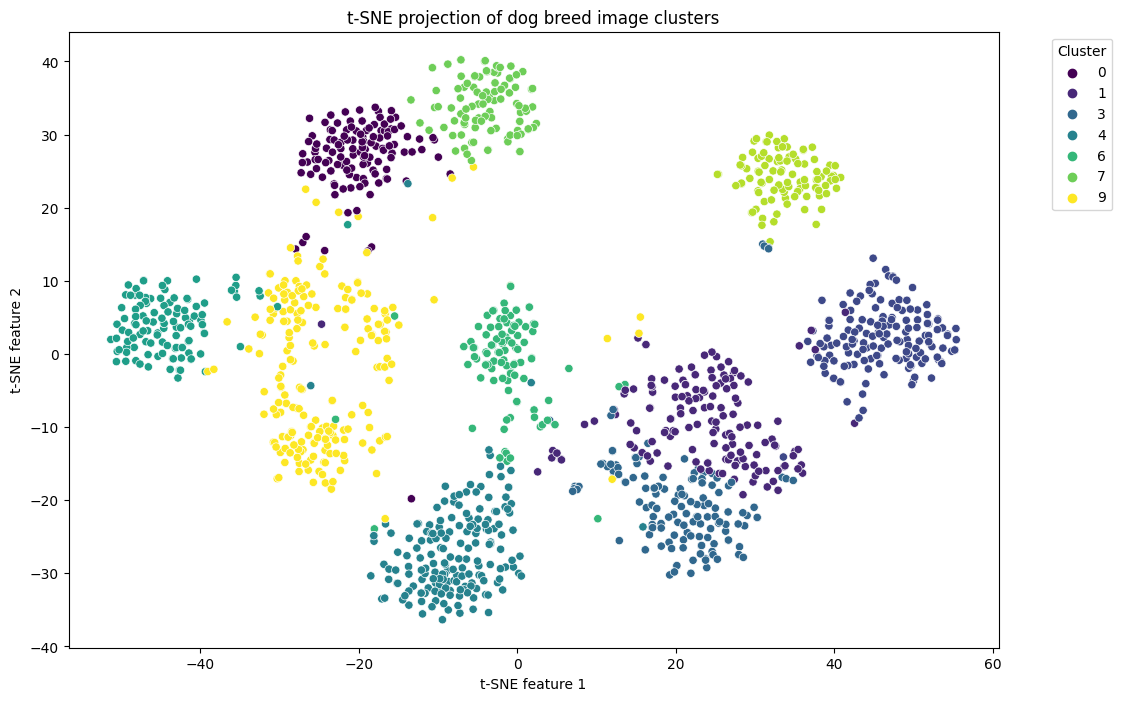

In [35]:
# Part 4 Alternative: t-SNE Visualization of Clusters

# Import necessary libraries
from sklearn.manifold import TSNE
import seaborn as sns

# Run t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Create a scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=embeddings_2d[:,0], y=embeddings_2d[:,1], hue=clusters, palette='viridis')

plt.title("t-SNE projection of dog breed image clusters")
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [36]:
from sklearn.metrics import silhouette_score

# Calculate the silhouette score
sil_score = silhouette_score(embeddings, clusters)

print(f"Silhouette Score: {sil_score}")


Silhouette Score: 0.11701299995183945
